In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde as GKDE

from scipy.stats import multivariate_normal
from scipy.stats import norm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.weightedCDFs as wCDFs
import src.weights as weights

import random

import matplotlib.patches as patches

import seaborn as sns

from mpl_toolkits import mplot3d
import matplotlib as mpl

# Fluid Flow Example

This notebook covers the example described in Section 5.2 of the paper.

In [2]:
plot_directory = './plots'

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5


CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

In [3]:
random.seed(20)

In [4]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

The data is generated as described in Section 5.2. Resulting data is stored for use in this notebook in the data directory. We load the data and visualize it below.

In [5]:
start_data = np.genfromtxt('./data/streams-initial-start.dat',
                           dtype=[('float'),('float'),('float')])
init_samples_full = []
for i in start_data:
    init_samples_full.append([i[0], i[1], i[2]])
init_samples_full = np.array(init_samples_full)

In [6]:
finish_data = np.genfromtxt('./data/streams-initial-finish.dat',
                            dtype=[('float'),('float'),('float')])
pred_samples_full = []
for i in finish_data:
    pred_samples_full.append([i[0], i[1], i[2]])
pred_samples_full = np.array(pred_samples_full)

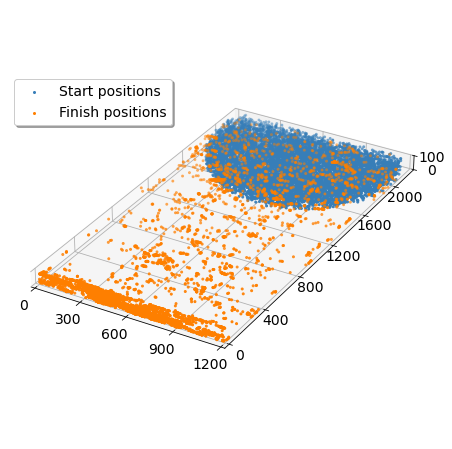

In [7]:
fig = plt.figure(figsize=(10,8));
ax = fig.add_subplot(projection='3d');
ax.scatter(init_samples_full[:,0], init_samples_full[:,1], init_samples_full[:,2],
           label='Start positions', s=4);
ax.scatter(pred_samples_full[:,0], pred_samples_full[:,1], pred_samples_full[:,2],
           label='Finish positions', s=4);
ax.set_ylim(0, 2200);
ax.set_xlim(0, 1200);
ax.set_zlim(0, 100);
ax.set_xticks([0,300,600,900,1200]);
ax.set_xticklabels([0,300,600,900,1200]);
ax.set_yticks([0,400,800,1200,1600,2000]);
ax.set_yticklabels([0,400,800,1200,1600,2000]);
ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), shadow=True);
ax.set_zticks([0,100]);
ax.set_zticklabels([0,100]);
ax.set_box_aspect([1.0, 1.83, 0.08]);

plt.savefig(f'{plot_directory}/fluid_flow_start_end.png', bbox_inches='tight');

Here, we extract the predicted and observed samples, which are the samples that are within 100 ft of the end of the domain.

In [8]:
pred_samples = pred_samples_full[pred_samples_full[:,1] < 100, :1]
init_samples = init_samples_full[pred_samples_full[:,1] < 100, :]
n_init_samples = len(init_samples)

In [9]:
n_obs_samples = 10000

obs_dist = norm(900, 25)

obs_samples = obs_dist.rvs((n_obs_samples,1))

For comparison, we find the solution using the density-based method and plot the results below.

In [10]:
pred_KDE = GKDE(pred_samples.T)
obs_KDE = GKDE(obs_samples.T)
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
PF_update_KDE = GKDE(pred_samples.T, weights=rn_w)

print(f'E(r) = {np.mean(r)}')

E(r) = 1.0767419390104662


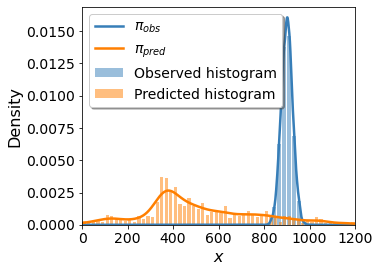

In [11]:
plt.hist(obs_samples, bins=10, density=True, label='Observed histogram', alpha=0.5, rwidth=0.8);
plt.hist(pred_samples, bins=60, density=True, label='Predicted histogram', alpha=0.5, rwidth=0.7);
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000);
plt.plot(xx, obs_KDE.pdf(xx), label='$\pi_{obs}$', c=CB_color_cycle[0]);
plt.plot(xx, pred_KDE.pdf(xx), label='$\pi_{pred}$', c=CB_color_cycle[1]);
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.0f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)]);
plt.xlim(np.min(xx), np.max(xx));
plt.xlabel(r'$x$');
plt.ylabel('Density');
plt.legend(shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/fluid_flow_samples.png', bbox_inches='tight');

Next, we compute the solution and visualize the results using the binning (with K-means) method.

In [12]:
n_clusters = 120
w, labels, centers, w_cluster = weights.computePartitionedWeights_kMeans_IID(init_samples,
                                                                             pred_samples,
                                                                             sample_set_2=obs_samples,
                                                                             n_clusters=n_clusters)

     pcost       dcost       gap    pres   dres
 0: -3.6785e-02 -1.2020e+02  1e+02  2e-16  2e+01
 1: -3.6976e-02 -1.4046e+00  1e+00  2e-15  2e-01
 2: -5.0592e-02 -2.0221e-01  2e-01  2e-15  3e-02
 3: -1.0630e-01 -1.9534e-01  9e-02  3e-15  1e-17
 4: -1.1318e-01 -1.2443e-01  1e-02  5e-15  5e-18
 5: -1.1667e-01 -1.1928e-01  3e-03  6e-15  4e-18
 6: -1.1746e-01 -1.1793e-01  5e-04  7e-15  4e-18
 7: -1.1762e-01 -1.1771e-01  9e-05  7e-15  3e-18
 8: -1.1765e-01 -1.1767e-01  2e-05  9e-15  3e-18
 9: -1.1766e-01 -1.1766e-01  5e-06  5e-15  3e-18
10: -1.1766e-01 -1.1766e-01  9e-07  1e-14  3e-18
11: -1.1766e-01 -1.1766e-01  2e-07  4e-15  3e-18
12: -1.1766e-01 -1.1766e-01  3e-08  5e-15  3e-18
Optimal solution found.


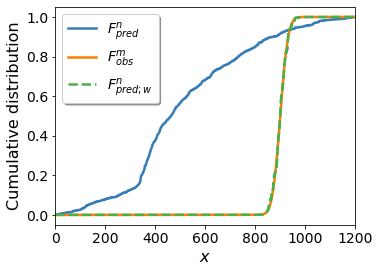

In [13]:
isort = np.argsort(pred_samples[:,0])
isort_obs = np.argsort(obs_samples[:,0])

plt.step(pred_samples[isort], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$F^n_{pred}$');
plt.step(np.append(0, np.append(obs_samples[isort_obs], [np.max(pred_samples)])),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), [1])),
         label=r'$F^m_{obs}$');
plt.step(pred_samples[isort], np.cumsum(w[isort]),
         label=r'$F^n_{pred;w}$', ls='dashed');
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);
plt.xlim(0,1200);

plt.xlabel(r'$x$');
plt.ylabel('Cumulative distribution');
plt.legend(loc='upper left', shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/fluid_flow_kmeans_cdfs.png', bbox_inches='tight');

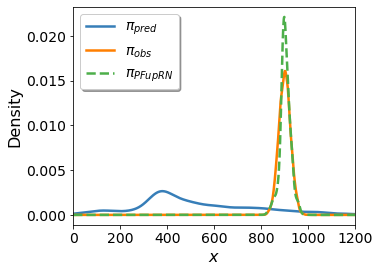

In [14]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

plt.plot(xx, pred_KDE(xx), label='$\pi_{pred}$');
plt.plot(xx, obs_KDE(xx), label='$\pi_{obs}$');
plt.plot(xx, PF_update_KDE(xx), label='$\pi_{PFupRN}$', ls='--');
plt.xticks(ticks=[0,200,400,600,800,1000,1200],
           labels=[0,200,400,600,800,1000,1200]);
plt.xlim(0,1200);

plt.xlabel(r'$x$');
plt.ylabel('Density');
plt.legend(loc='upper left', shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/fluid_flow_kmeans_pdfs.png', bbox_inches='tight');

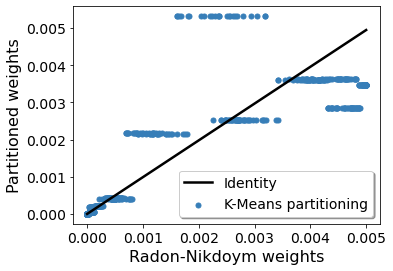

In [15]:
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikdoym weights');
plt.ylabel('Partitioned weights');
plt.scatter(rn_w, w, label='K-Means partitioning');
plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(w), np.max(rn_w), 6)]);
plt.legend(shadow=True);

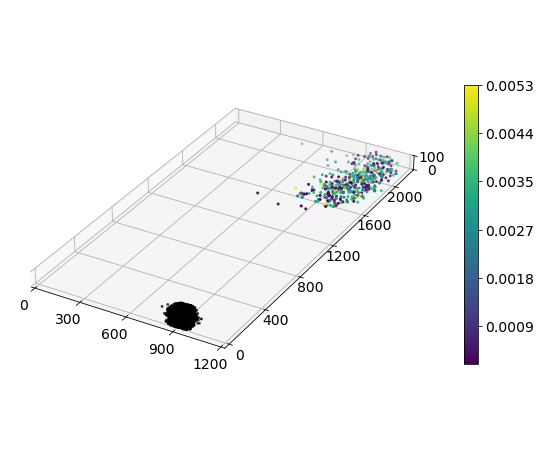

In [16]:
fig = plt.figure(figsize=(10,8));
ax = fig.add_subplot(projection='3d');

tolerance = 0.0001

p = ax.scatter(init_samples[w > tolerance,0], init_samples[w > tolerance,1], init_samples[w>tolerance,2],
               c=w[w > tolerance], label='Start positions', s=4);
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Finish positions', s=4);

ax.set_ylim(0, 2200);
ax.set_xlim(0, 1200);
ax.set_zlim(0, 100);
ax.set_xticks([0,300,600,900,1200]);
ax.set_xticklabels([0,300,600,900,1200]);
ax.set_yticks([0,400,800,1200,1600,2000]);
ax.set_yticklabels([0,400,800,1200,1600,2000]);
ax.set_zticks([0,100]);
ax.set_zticklabels([0,100]);

cbar = fig.colorbar(p, ax=ax, fraction=0.025, pad=0.04);
cbar.set_ticks(np.linspace(np.min(w), np.max(w), 7));
cbar.ax.set_yticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w), np.max(w), 7)]);

ax.set_box_aspect([1.0, 1.83, 0.08]);

plt.savefig(f'{plot_directory}/fluid_flow_kmeans_res.png', bbox_inches='tight');

In [17]:
update_inds = rejection_sampling(rn_w)

update_samples = init_samples[update_inds]
n_update_samples = len(update_samples)

pf_samples = pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

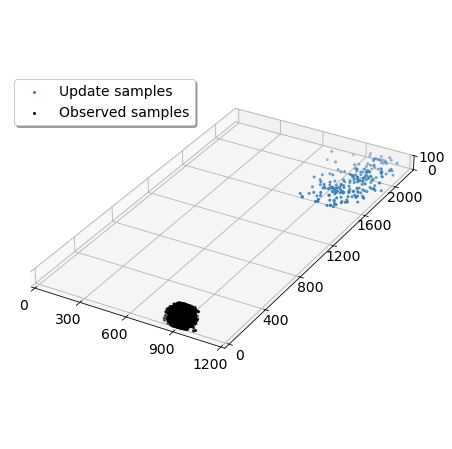

In [18]:
fig = plt.figure(figsize=(10,8));
ax = fig.add_subplot(projection='3d');

ax.scatter(update_samples[:,0], update_samples[:,1], update_samples[:,2], s=4, label='Update samples');
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Observed samples', s=4);

ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), shadow=True);

ax.set_ylim(0, 2200);
ax.set_xlim(0, 1200);
ax.set_zlim(0, 100);
ax.set_xticks([0,300,600,900,1200]);
ax.set_xticklabels([0,300,600,900,1200]);
ax.set_yticks([0,400,800,1200,1600,2000]);
ax.set_yticklabels([0,400,800,1200,1600,2000]);
ax.set_zticks([0,100]);
ax.set_zticklabels([0,100]);

ax.set_box_aspect([1.0, 1.83, 0.08]);

plt.savefig(f'{plot_directory}/fluid_flow_density_res_rej.png', bbox_inches='tight');

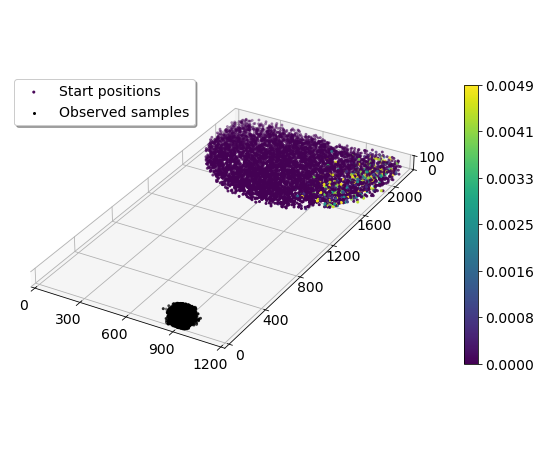

In [19]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')

p = ax.scatter(init_samples[:,0], init_samples[:,1], init_samples[:,2],
               c=rn_w, label='Start positions', s=4)
ax.scatter(obs_samples, np.random.uniform(0, 100, (n_obs_samples,1)),
           np.random.uniform(0, 100, (n_obs_samples,1)),
           color='k', label='Observed samples', s=4)

ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), shadow=True)

ax.set_ylim(0, 2200)
ax.set_xlim(0, 1200)
ax.set_zlim(0, 100)
ax.set_xticks([0,300,600,900,1200])
ax.set_xticklabels([0,300,600,900,1200])
ax.set_yticks([0,400,800,1200,1600,2000])
ax.set_yticklabels([0,400,800,1200,1600,2000])
ax.set_zticks([0,100])
ax.set_zticklabels([0,100])

cbar = fig.colorbar(p, ax=ax, fraction=0.025, pad=0.04)
cbar.set_ticks(np.linspace(np.min(rn_w), np.max(rn_w), 7));
cbar.ax.set_yticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 7)]);

ax.set_box_aspect([1.0, 1.83, 0.08])

plt.savefig(f'{plot_directory}/fluid_flow_density_res.png', bbox_inches='tight')

Finally, we plot the marginals of the solution and compare the methods below.

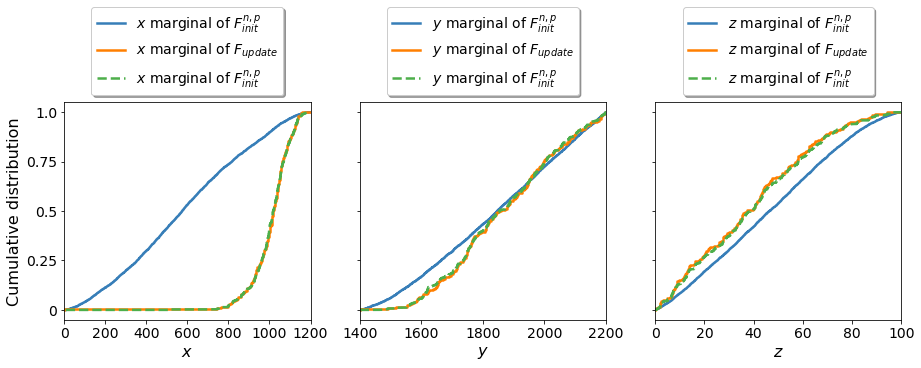

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4));

isort = np.argsort(init_samples[:,0])
isort_up = np.argsort(update_samples[:,0])
ax1.set_ylabel('Cumulative distribution');

# x -------------------------------------------
ax1.step(init_samples[isort,0], np.cumsum([1/n_init_samples]*n_init_samples),
         label='$x$ marginal of $F^{n,p}_{init}$');
ax1.step(np.append(0, np.append(update_samples[isort_up,0], [np.max(init_samples[:,0])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$x$ marginal of $F_{update}$');
ax1.step(init_samples[isort,0], np.cumsum(w[isort]),
         label='$x$ marginal of $F^{n,p}_{init}$', ls='dashed');
ax1.set_xticks([0,200,400,600,800,1000,1200]);
ax1.set_xticklabels([0,200,400,600,800,1000,1200]);
ax1.set_xlim(0,1200);
ax1.set_yticks([0,0.25, 0.5, 0.75, 1.0]);
ax1.set_yticklabels([0,0.25, 0.5, 0.75, 1.0]);

ax1.set_xlabel(r'$x$');

ax1.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# y -----------------------------------
isort = np.argsort(init_samples[:,1])
isort_up = np.argsort(update_samples[:,1])

ax2.step(np.append(1400, init_samples[isort,1]), np.append(0,np.cumsum([1/n_init_samples]*n_init_samples)),
         label='$y$ marginal of $F^{n,p}_{init}$');
ax2.step(np.append([1400], np.append(update_samples[isort_up,1], [np.max(init_samples[:,1])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$y$ marginal of $F_{update}$');
ax2.step(np.append(1400, init_samples[isort,1]), np.append(0, np.cumsum(w[isort])),
         label='$y$ marginal of $F^{n,p}_{init}$', ls='dashed');
ax2.set_xticks([1400,1600,1800,2000,2200]);
ax2.set_xticklabels(labels=[1400,1600,1800,2000,2200]);
ax2.set_xlim(1400,2200);

ax2.set_xlabel(r'$y$');

ax2.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));

# z -----------------------------------
isort = np.argsort(init_samples[:,2])
isort_up = np.argsort(update_samples[:,2])

ax3.step(init_samples[isort,2], np.cumsum([1/n_init_samples]*n_init_samples),
         label='$z$ marginal of $F^{n,p}_{init}$');
ax3.step(np.append([np.min(init_samples[:,2])], np.append(update_samples[isort_up,2], [np.max(init_samples[:,2])])),
         np.append(0, np.append(np.cumsum([1/n_update_samples]*n_update_samples), [1])),
         label='$z$ marginal of $F_{update}$');
ax3.step(init_samples[isort,2], np.cumsum(w[isort]),
         label='$z$ marginal of $F^{n,p}_{init}$', ls='dashed');

ax3.set_xticks([0,20,40,60,80,100]);
ax3.set_xticklabels(labels=[0,20,40,60,80,100]);
ax3.set_xlim(0,100);
ax3.set_xlabel(r'$z$');

ax3.legend(shadow=True, loc='lower center', bbox_to_anchor=(0.5, 1));